In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, UpSampling2D, Activation, Flatten, Dense, MaxPooling2D, Conv2DTranspose, Add, Reshape
from keras.models import Model
from keras.optimizers import Adam
import requests
from PIL import Image
# from keras.datasets import cifar10, mnist

In [ ]:
def get_imgs(folder_path):

    # List all files in the folder
    file_names = os.listdir(folder_path)

    # Filter out only image files (assuming they have common image extensions)
    image_files = [f for f in file_names if f.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]

    image_files.sort()

    # Load images into a list
    images = []
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)
        images.append(np.array(image))

    images_array = np.stack(images)

    return images_array

In [ ]:
!git clone https://github.com/marknader11/ultrasound_denoise.git

Cloning into 'ultrasound_denoise'...
remote: Enumerating objects: 585, done.
remote: Counting objects: 100% (585/585), done.
remote: Compressing objects: 100% (584/584), done.
remote: Total 585 (delta 1), reused 585 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (585/585), 1.86 MiB | 4.96 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# Specify the folder containing the images
ctrp = '/content/ultrasound_denoise/clean_train'
ctsp = '/content/ultrasound_denoise/clean_test'
ntrp = '/content/ultrasound_denoise/noisy_test'
ntsp = '/content/ultrasound_denoise/noisy_test'

n = 255

clean_train = get_imgs(ctrp)/n
clean_test = get_imgs(ctsp)/n
noisy_train = get_imgs(ntrp)/n
noisy_test = get_imgs(ntsp)/n


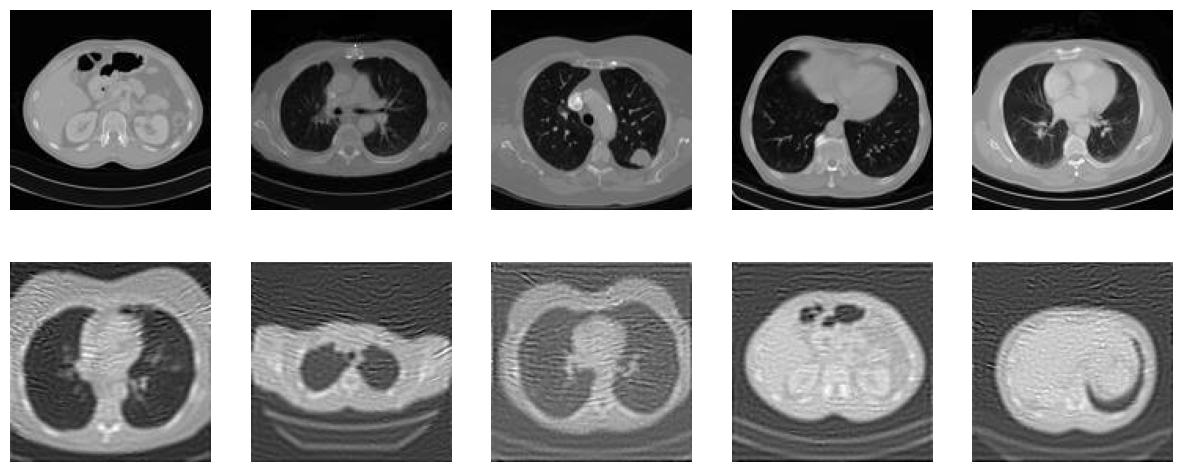

In [ ]:
# Now 'images_array' contains all the images from the folder
plt.figure(figsize=(15, 6))
for i in range(1, 6):
    plt.subplot(2, 5, i)
    plt.imshow(clean_train[i], cmap='gray')
    plt.axis('off')
    plt.subplot(2, 5, i+5)
    plt.imshow(noisy_train[i], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:

def build_generator(): #meh
    input_img = Input(shape=(128, 128, 1))

    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    skip1 = x

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    skip2 = x

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Add()([x, skip2])

    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Add()([x, skip1])

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2D(1, (3, 3), padding='same')(x)
    output_img = Activation('tanh')(x)

    return Model(input_img, output_img)

generator = build_generator()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ leaky_re_lu[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 128)    │            512 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 32, 256)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 256)    │          1,024 │ leaky_re_lu_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 128)    │        524,416 │ batch_normalization_2… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ leaky_re_lu_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
│                      

 Total params: 1,065,537 (4.06 MB)

 Trainable params: 1,064,129 (4.06 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
epochs = 200
startup_epochs = 10
BATCH_SIZE = 64
save_interval = 25
image_interval = 5

valid = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
acc_metric = tf.keras.metrics.BinaryAccuracy()
disc_optim = Adam()
gen_optim = Adam()

generator = build_generator()

with tf.device('/gpu:0'):
  for epoch in range(epochs):
      idx = np.random.randint(0, noisy_train.shape[0], BATCH_SIZE)
      clean_imgs = clean_train[idx]
      noisy_imgs = noisy_train[idx]
      clean_imgs = tf.cast(clean_imgs, dtype=tf.float32) # Cast clean_imgs to float32

      # We keep all the gradients of anything here
      with tf.GradientTape() as tape:
        # Generator
        gen_imgs = generator(noisy_imgs)
        gen_imgs = tf.squeeze(gen_imgs)
        # Discrimantor
        features = tf.concat([gen_imgs, clean_imgs], axis=0)
        labels = tf.concat([fake, valid], axis=0)
        pred_labels = discriminator(features)
        disc_loss = bce(labels, pred_labels)
        acc = acc_metric(labels, pred_labels)
        acc = 1 - tf.reduce_mean(tf.image.ssim(clean_imgs, gen_imgs, max_val=1.0))
        gen_loss = tf.keras.losses.MSE(clean_imgs, gen_imgs)


        if epoch < startup_epochs:
          disc_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)
          disc_optim.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
          print(f"{epoch} disc_loss is {disc_loss} and acc is {acc}")
        else:
          gen_gradients = tape.gradient(gen_loss, generator.trainable_variables)
          gen_optim.apply_gradients(zip(gen_gradients, generator.trainable_variables))
          print(f"{epoch} gen_loss is {gen_loss} and acc is {acc}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


0 disc_loss is 0.6923628449440002 and acc is 0.46875
1 disc_loss is 0.6887966990470886 and acc is 0.61328125
2 disc_loss is 0.6827126741409302 and acc is 0.7395833134651184
3 disc_loss is 0.676724910736084 and acc is 0.78515625
4 disc_loss is 0.6666660308837891 and acc is 0.8218749761581421
5 disc_loss is 0.6498818397521973 and acc is 0.8515625
6 disc_loss is 0.6321101188659668 and acc is 0.8716517686843872
7 disc_loss is 0.5889976024627686 and acc is 0.88671875
8 disc_loss is 0.554408848285675 and acc is 0.8984375
9 disc_loss is 0.5116778016090393 and acc is 0.90625
10 gen_loss is [[0.01090385 0.00043238 0.00359582 ... 0.0018921  0.00519504 0.00053032]
 [0.00774206 0.00021198 0.00138575 ... 0.00060988 0.0025218  0.00025402]
 [0.00547904 0.00010254 0.00262437 ... 0.0033889  0.00289794 0.0008919 ]
 ...
 [0.00968303 0.00023311 0.00289151 ... 0.00082905 0.00443414 0.00030421]
 [0.00768296 0.00020776 0.00211723 ... 0.00144518 0.00350291 0.00052216]
 [0.01058503 0.00023445 0.00346134 ... 0.

In [ ]:
# Test the generator with noisy test images
gen_imgs = generator((noisy_test))

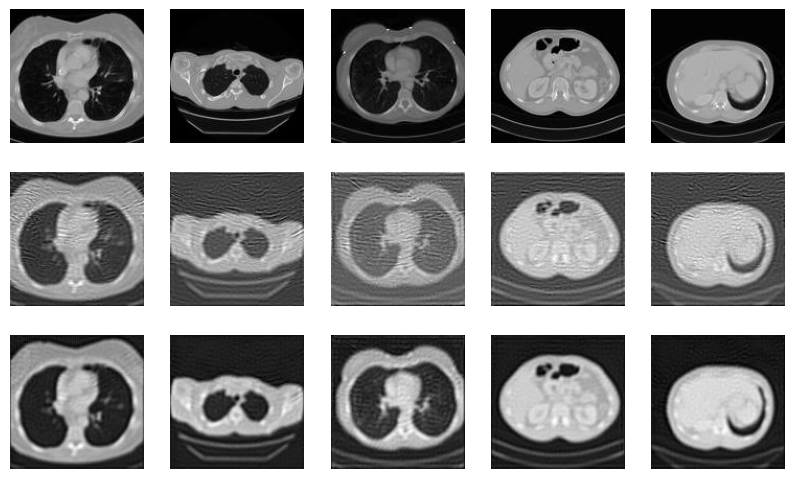

In [ ]:
# Plot the results
mod = 0

# Now 'images_array' contains all the images from the folder

# plt.figure(figsize=(10, 6))
# plt.subplot(2, 1, 1)
# plt.imshow(clean_test[0], cmap='gray')
# plt.axis('off')
# plt.subplot(2, 1, 2)
# plt.imshow(gen_imgs[0], cmap='gray')
# plt.axis('off')
# # plt.subplot(3, 5, i+10)
# # plt.imshow(gen_imgs[i+mod], cmap='gray')
# # plt.axis('off')
# plt.show()


plt.figure(figsize=(10, 6))
for i in range(1, 6):
    plt.subplot(3, 5, i)
    plt.imshow(clean_test[i+mod], cmap='gray')
    plt.axis('off')
    plt.subplot(3, 5, i+5)
    plt.imshow(noisy_test[i+mod], cmap='gray')
    plt.axis('off')
    plt.subplot(3, 5, i+10)
    plt.imshow(gen_imgs[i+mod], cmap='gray')
    plt.axis('off')
plt.show()